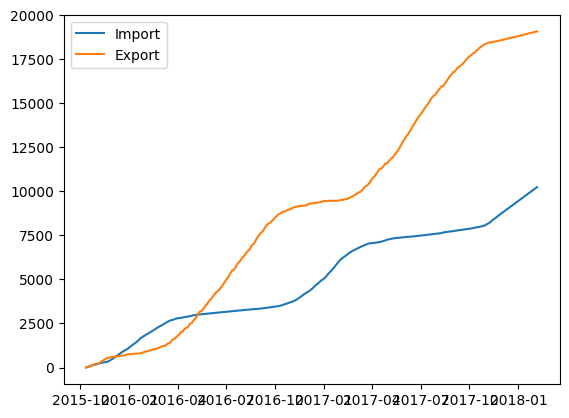

Selected features: ['hour_of_day', 'temp', 'day_of_week', 'season_Summer', 'season_Winter', 'month', 'season_Spring', 'season_Autumn', 'holiday', 'DE_KN_residential4_grid_export']
MAE: 496.4598754701215


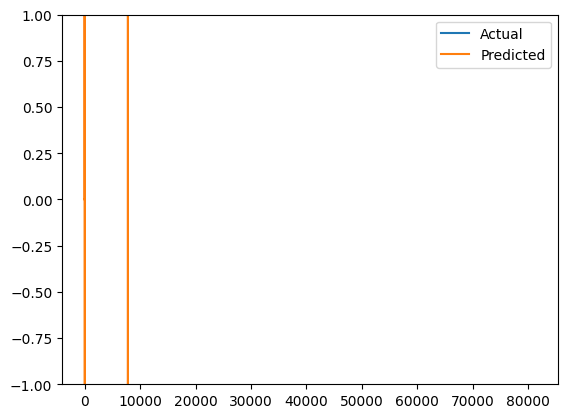

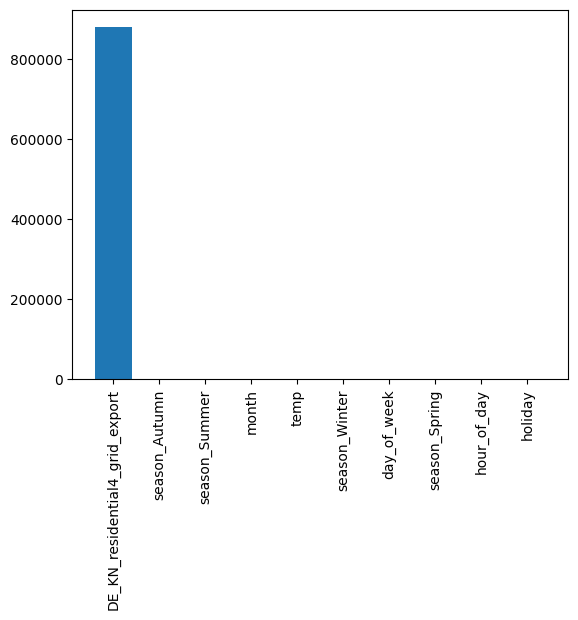

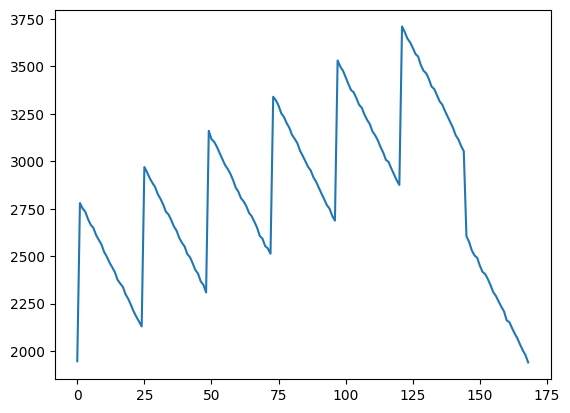

In [4]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('residential4_grid_import_export_weather_fixed_timestamps.csv')

# Convert the 'utc_timestamp' column to datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df['DE_KN_residential4_grid_import'] = df['DE_KN_residential4_grid_import'].diff()
df['DE_KN_residential4_grid_export'] = df['DE_KN_residential4_grid_export'].diff()

#Aplly a rolling mean to the import
df['DE_KN_residential4_grid_import'] = df['DE_KN_residential4_grid_import'].rolling(24*4).mean()
df['DE_KN_residential4_grid_export'] = df['DE_KN_residential4_grid_export'].rolling(24*4).mean()

df = df.dropna()
# Extract day of the week and hour of the day
df['day_of_week'] = df['utc_timestamp'].dt.dayofweek
df['hour_of_day'] = df['utc_timestamp'].dt.hour
df['month'] = df['utc_timestamp'].dt.month


#plot import and export
plt.plot(df['utc_timestamp'], df['DE_KN_residential4_grid_import'], label='Import')
plt.plot(df['utc_timestamp'], df['DE_KN_residential4_grid_export'], label='Export')
plt.legend()
plt.show()




# Define the features and the target
features = ['hour_of_day', 'DE_KN_residential4_grid_export', 'temp','day_of_week','season_Summer','season_Winter','month','season_Spring','season_Autumn','holiday']
target = 'DE_KN_residential4_grid_import'

# Create a feature selector
selector = SelectKBest(score_func=f_regression, k=2)

# Fit the selector to the data
selector.fit(df[features], df[target])

# Get the selected features
mask = selector.get_support()
selected_features = [f for f, m in zip(features, mask) if m]
selected_features = ['hour_of_day', 'temp','day_of_week','season_Summer','season_Winter','month','season_Spring','season_Autumn','holiday','DE_KN_residential4_grid_export']

print(f'Selected features: {selected_features}')

# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.PARegressor(
    C=0.01,
    mode=2,
    eps=0.1,
    learn_intercept=False
    )
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')

# Plot the actual vs predicted values
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.ylim(-1, 1)
plt.legend()
plt.show()

# Get the scores
scores = selector.scores_

# Create a list of tuples (feature, score)
feature_scores = list(zip(features, scores))

# Sort the features by score
sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Plot the feature scores
plt.bar(*zip(*sorted_features))
plt.xticks(rotation=90)
plt.show()

# Predict for the next year
start_date = df['utc_timestamp'].max() + pd.Timedelta(days=1)
end_date = start_date + pd.DateOffset(days=7)
dates = pd.date_range(start_date, end_date, freq='H')

predictions_next_year = []
for date in dates:
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        'temp': np.random.rand(),  # Example: random value
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_year.append(y_pred)

# Plot the predictions for the next year
plt.plot(predictions_next_year)
plt.show()

from river import linear_model
from river import metrics
from river import stream
import numpy as np

# Prepare your data
X = df[selected_features].values
y = df[target].values

# Define the parameter grid
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
eps_values = [0.01, 0.1, 1.0]

# Prepare a dictionary to store the results
results = {}

# Iterate over the parameter grid
for C in C_values:
    for eps in eps_values:
        # Create and train the model
        model = linear_model.PARegressor(C=C, mode=2, eps=eps, learn_intercept=False)
        metric = metrics.MAE() + metrics.MSE()

        for xi, yi in stream.iter_array(X, y):
            y_pred = model.predict_one(xi)
            model.learn_one(xi, yi)
            metric.update(yi, y_pred)

        # Store the results
        results[(C, eps)] = metric

# Print the results
for params, metric in results.items():
    print(f'Parameters: {params}, Metric: {metric}')
    
    
#show the best parameters
best_params = min(results, key=results.get)
print(f'Best parameters: {best_params}')
print(f'Best metric: {results[best_params]}')


In [5]:
df = df.set_index('utc_timestamp')

2018-02-04 23:00:00
2018-02-05 00:00:00
2018-02-05 00:00:00
2019-02-04 23:00:00
2019-02-04 23:00:00
DatetimeIndex(['2018-02-05 00:00:00', '2018-02-05 00:15:00',
               '2018-02-05 00:30:00', '2018-02-05 00:45:00',
               '2018-02-05 01:00:00', '2018-02-05 01:15:00',
               '2018-02-05 01:30:00', '2018-02-05 01:45:00',
               '2018-02-05 02:00:00', '2018-02-05 02:15:00',
               ...
               '2019-02-04 20:45:00', '2019-02-04 21:00:00',
               '2019-02-04 21:15:00', '2019-02-04 21:30:00',
               '2019-02-04 21:45:00', '2019-02-04 22:00:00',
               '2019-02-04 22:15:00', '2019-02-04 22:30:00',
               '2019-02-04 22:45:00', '2019-02-04 23:00:00'],
              dtype='datetime64[ns]', length=35037, freq='15min')


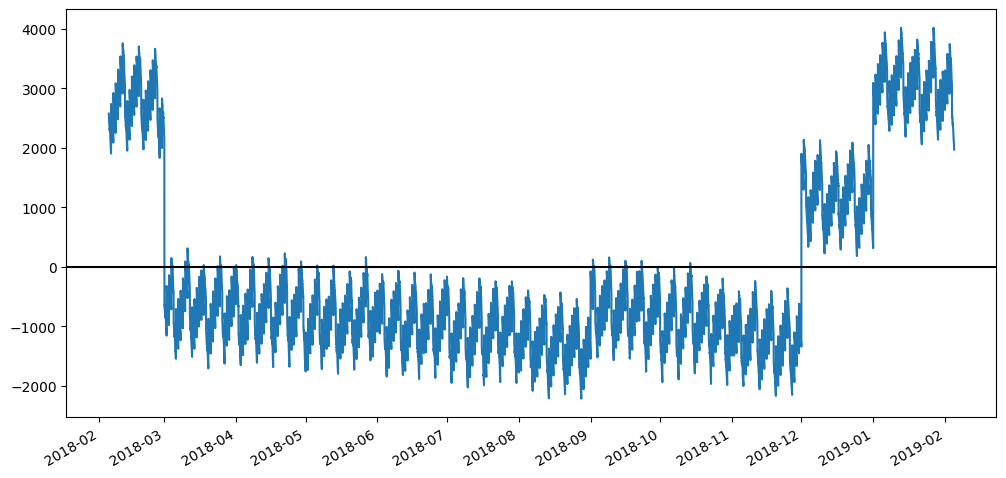

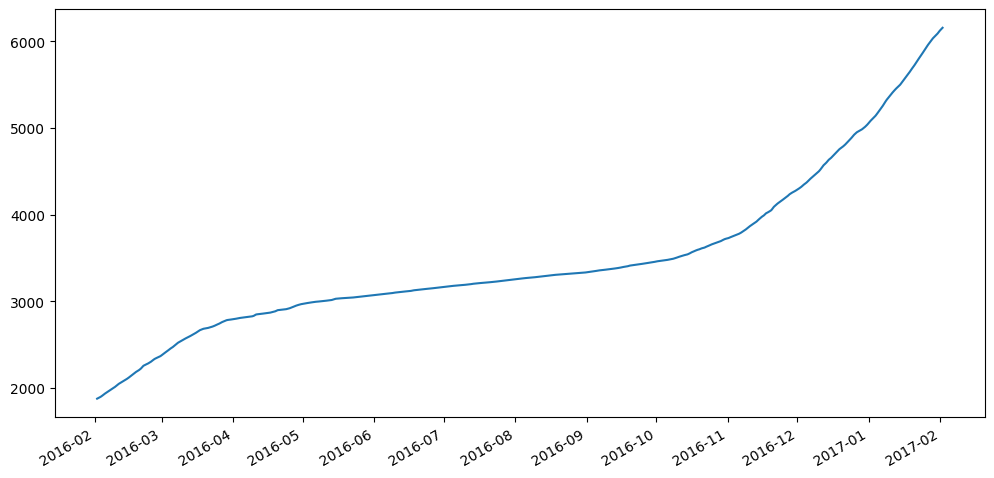

In [6]:

from meteostat import Point, Hourly
import matplotlib.dates as mdates

#set utc_timestamp as index



# Define the number of steps ahead to predict
steps_ahead = 24*4*365


# Create Point for Brussels
location = Point(50.8503, 4.3517)

# Get the last date in your existing data
print(df.index.max())
last_date = df.index.max()

# Calculate the start and end dates based on the steps_ahead variable
start = last_date + pd.Timedelta(minutes=15)
end = start + pd.Timedelta(minutes=15*steps_ahead)


# Get hourly data for the specified period
weather_data = Hourly(location, start, end)
weather_data = weather_data.fetch()

# Interpolate to every 15 minutes
weather_data = weather_data.resample('15min').interpolate()

# Add a column for weather type
weather_data['weather_type'] = weather_data['prcp']
#print(weather_data)
# Select only the temperature and weather type columns
weather_data = weather_data[['temp']]
print(weather_data.index.min())
#print(weather_data)
# Calculate the start and end dates for the predictions
start_date = pd.Timestamp(weather_data.index.min())
print(start_date)
print(weather_data.index.max())
end_date = weather_data.index.max()
print(end_date)
dates = pd.date_range(start_date, end_date, freq='15min')
print(dates)


predictions_next_year = []
for date in dates:
    # Get the weather data for this date

    temp = weather_data.loc[date, 'temp']
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        'temp': temp,
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_year.append(y_pred)
    
# Plot the predictions for the next year
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions_next_year)
#draw line on x-axis
plt.axhline(y=0, color='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

#plot the actual values of a year
#select the first year of the data
df = df.loc['2016-02-02':'2017-02-1']




plt.figure(figsize=(12, 6))
plt.plot(df.index, df['DE_KN_residential4_grid_import'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()


